In [60]:
import numpy as np
import pandas as pd
import subprocess

from IPython.display import Image

from collections import Counter

from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, accuracy_score

# Regressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

import gc

In [2]:
## print('Loading data ...')

train = pd.read_csv('../train_2016_v2.csv')
prop = pd.read_csv('../properties_2016.csv')
sample = pd.read_csv('../sample_submission.csv')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/io/parsers.py:1150: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
print('Binding to float32')

for c, dtype in zip(prop.columns, prop.dtypes):
    if dtype == np.float64:
        prop[c] = prop[c].astype(np.float32)

print('Creating training set ...')

df_train = train.merge(prop, how='left', on='parcelid').fillna(0)

x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc',\
                         'propertycountylandusecode'], axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

del df_train; gc.collect()

split = 80000
X_train, y_train, X_test, y_test = x_train[:split], y_train[:split], x_train[split:], y_train[split:]


Binding to float32
Creating training set ...
((90275, 55), (90275,))


### Single Decision Tree 

In [42]:
from sklearn.metrics import mean_squared_error

decision_tree = DecisionTreeRegressor()

# train classifier
decision_tree.fit(X_train, y_train)

# predict output
decision_tree_y_pred  = decision_tree.predict(X_test)
#decision_tree_y_pred_prob  = decision_tree.predict_proba(X_test)

# evaluation
#decision_tree_accuracy = accuracy_score(y_test, decision_tree_y_pred)
#decision_tree_logloss = log_loss(y_test, decision_tree_y_pred_prob)
mse = mean_squared_error(y_test, decision_tree.predict(X_test))

print("== Decision Tree ==")
print "Accuracy/R**2 on the train dataset: %.4g" % decision_tree.score(X_train, y_train)
print "Accuracy/R**2 on the test dataset: %.4g" % decision_tree.score(X_test, y_test)
print("MSE: %f" % mse)

== Decision Tree ==
Accuracy/R**2 on the train dataset: 0.9992
Accuracy/R**2 on the test dataset: -1.284
MSE: 0.051395


In [33]:
print('True labels vs Predicted Labels for test')
print(y_test[:5,], decision_tree.predict(X_test)[:5,])
print('True labels vs Predicted Labels for train')
print(y_train[:5,], decision_tree.predict(X_train)[:5,])

True labels vs Predicted Labels for test
(array([ 0.1017, -0.1649,  0.0218,  0.1458, -0.005 ]), array([ 0.0602,  0.077 ,  0.0247,  0.002 ,  0.0325]))
True labels vs Predicted Labels for train
(array([ 0.0276, -0.1684, -0.004 ,  0.0218, -0.005 ]), array([ 0.0276, -0.1684, -0.004 ,  0.0218, -0.005 ]))


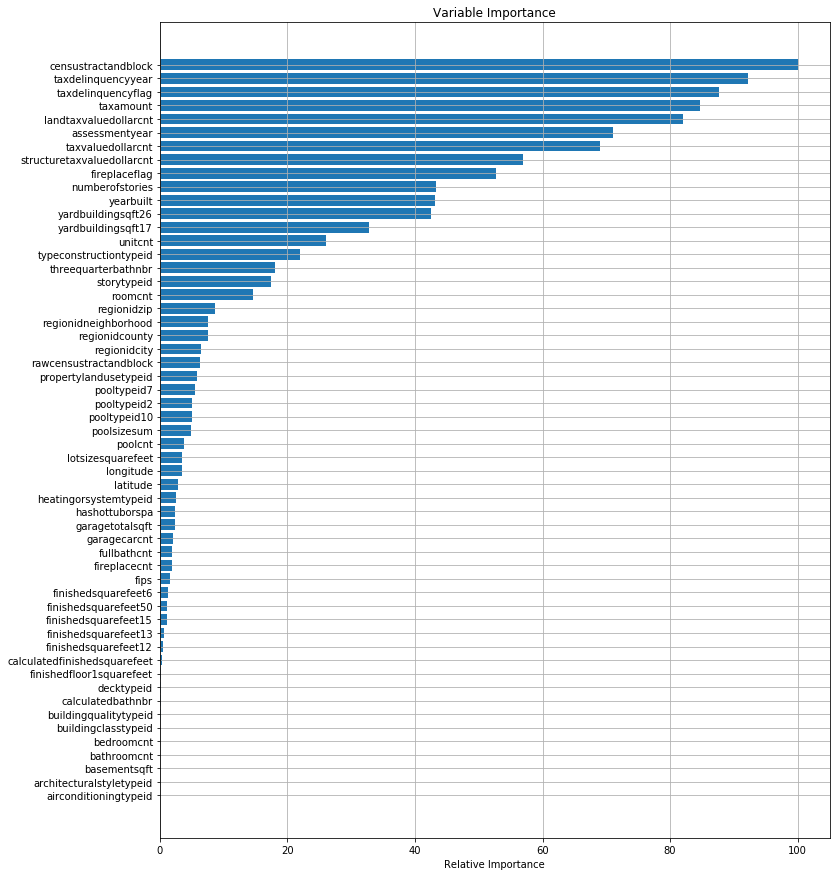

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

# #############################################################################
# Plot feature importance
feature_importance = decision_tree.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance) #Returns the indices that would sort an array.
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 15))
#plt.subplot(212)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.grid()

plt.show()

### AdaBoost 
In the example below we are creating a AdaBoost classifier running on 1000 iterations (1000 trees created). Also we are growing decision node up to first split (they are called decision stumps). We are also going to use SAMME algorithm which is inteneded to work with discrete data (output from base_estimator is 0 or 1).

An AdaBoost [1] regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.

In [51]:
adaboost = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=8),
    n_estimators=1000
    )

# train classifier
adaboost.fit(X_train, y_train)

# calculate predictions
adaboost_y_pred = adaboost.predict(X_test)
#adaboost_y_pred_prob = adaboost.predict_proba(X_test)

# evaluate
#adaboost_accuracy = accuracy_score(y_test, adaboost_y_pred)
#adaboost_logloss = log_loss(y_test, adaboost_y_pred_prob)

mse = mean_squared_error(y_test, adaboost.predict(X_test))

print("== AdaBoost ==")
print "Accuracy/R**2 on the train dataset: %.4g" % adaboost.score(X_train, y_train)
print "Accuracy/R**2 on the test dataset: %.4g" % adaboost.score(X_test, y_test)
print("MSE: %f" % mse)

== AdaBoost ==
Accuracy/R**2 on the train dataset: -2.436
Accuracy/R**2 on the test dataset: -3.655
MSE: 0.104744


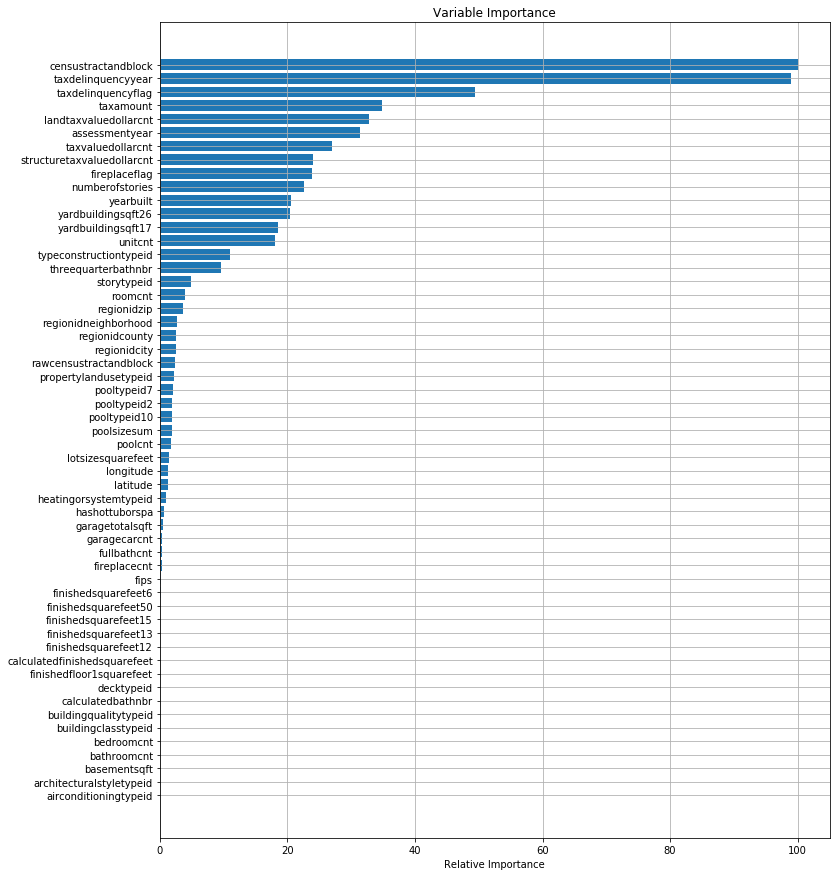

In [52]:
# #############################################################################
# Plot feature importance
feature_importance = adaboost.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance) #Returns the indices that would sort an array.
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 15))
#plt.subplot(212)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.grid()

plt.show()

### Gradient Boosted Trees
Let's construct a gradient boosted tree consiting of 1000 trees where each successive one will be created with gradient optimization. Again we are going to leave most parameters with their default values, specifiy only maximum depth of the tree to 1 (again decision stumps), and setting warm start for more intelligent computations.

In [53]:
# Fit regression model
params = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 4,
          'learning_rate': 0.1, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
#Predict training set:
#dtrain_predictions = clf.predict(X_train)
#dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]


mse = mean_squared_error(y_test, clf.predict(X_test))

#Print model report:
print "\nModel Report"
print "Accuracy on the train dataset: %.4g" % clf.score(X_train, y_train)
print "Accuracy on the test dataset: %.4g" % clf.score(X_test, y_test)

print("MSE: %.4f" % mse)


Model Report
Accuracy on the train dataset: 0.5084
Accuracy on the test dataset: -0.07517
MSE: 0.0242


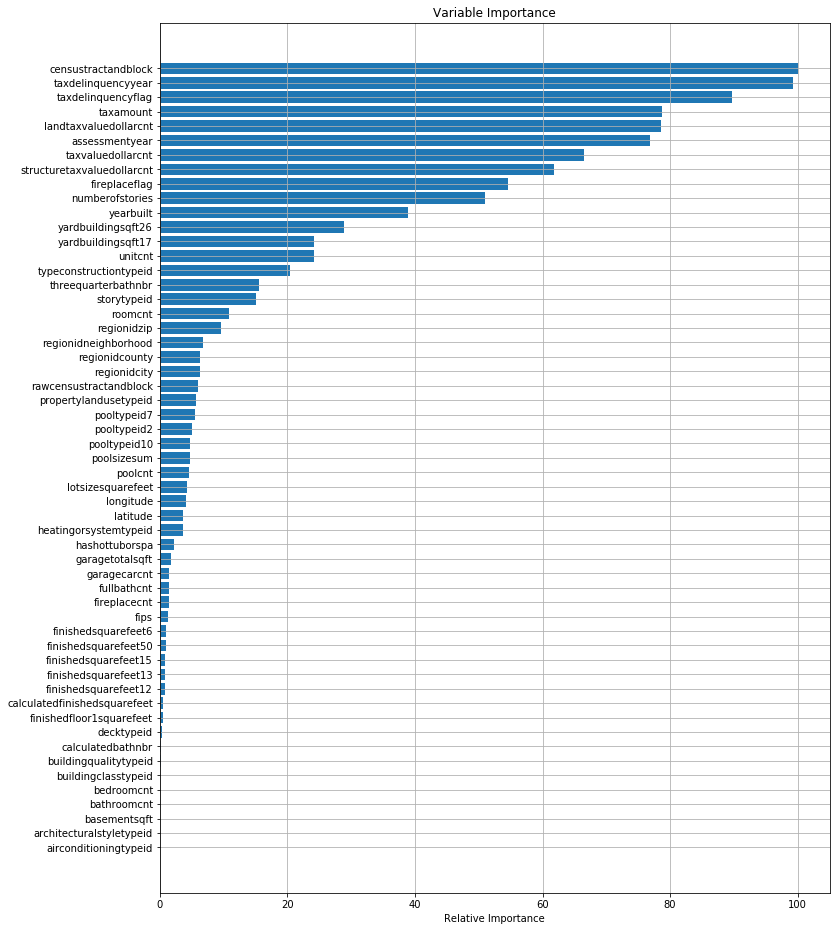

In [56]:
# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance) #Returns the indices that would sort an array.
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 16))
#plt.subplot(212)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.grid()

plt.show()

Important: XGBoost handles only numeric variables.

XGBoost (Extreme Gradient Boosting) is an optimized distributed gradient boosting library. Yes, it uses gradient boosting (GBM) framework at core. Yet, does better than GBM framework alone. XGBoost was created by Tianqi Chen, PhD Student, University of Washington. It is used for supervised ML problems.  Let's look at what makes it so good:

- Parallel Computing: It is enabled with parallel processing (using OpenMP); i.e., when you run xgboost, by default, it would use all the cores of your laptop/machine.
- Regularization: I believe this is the biggest advantage of xgboost. GBM has no provision for regularization. Regularization is a technique used to avoid overfitting in linear and tree-based models.
- Enabled Cross Validation: In R, we usually use external packages such as caret and mlr to obtain CV results. But, xgboost is enabled with internal CV function (we'll see below).
- Missing Values: XGBoost is designed to handle missing values internally. The missing values are treated in such a manner that if there exists any trend in missing values, it is captured by the model.
- Flexibility: In addition to regression, classification, and ranking problems, it supports user-defined objective functions also. An objective function is used to measure the performance of the model given a certain set of parameters. Furthermore, it supports user defined evaluation metrics as well.
- Availability: Currently, it is available for programming languages such as R, Python, Java, Julia, and Scala.
- Save and Reload: XGBoost gives us a feature to save our data matrix and model and reload it later. Suppose, we have a large data set, we can simply save the model and use it in future instead of wasting time redoing the computation.
- Tree Pruning: Unlike GBM, where tree pruning stops once a negative loss is encountered, XGBoost grows the tree upto max_depth and then prune backward until the improvement in loss function is below a threshold.


In [62]:
import xgboost as xgb

In [67]:
params = {
    'objective':'reg:linear',
    'max_depth':2,
    'silent':1,
    'eta':1
}

num_rounds = 5

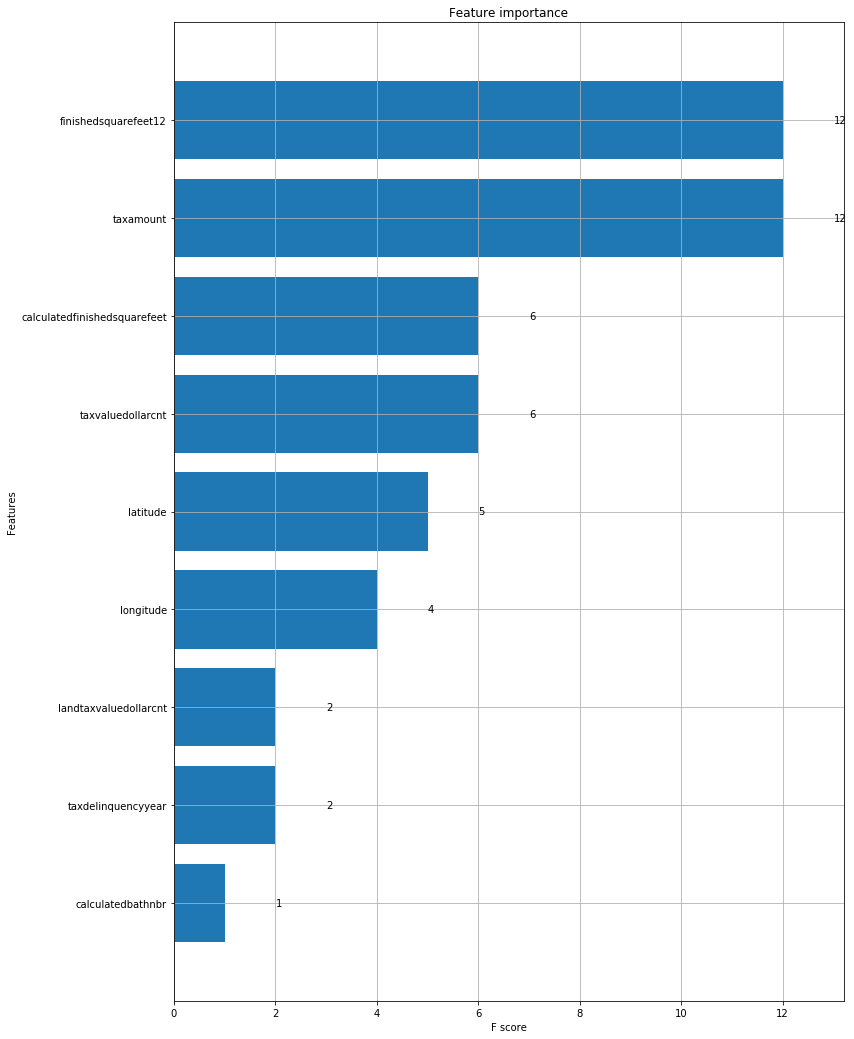

In [72]:
feature_names = X_train.columns.values


xgb_params = {
    'eta': 0.05,
    'max_depth': 1,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=feature_names)

dtest = xgb.DMatrix(X_test, y_test, feature_names=feature_names)

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()  

In [73]:
model.predict(dtest)

array([ 0.05526897,  0.0480687 ,  0.04578105, ...,  0.05527368,
        0.04808331,  0.04726562], dtype=float32)